In [1]:
!unzip /content/drive/MyDrive/datasets/hymenoptera_data.zip -d /content/drive/MyDrive/datasets

Archive:  /content/drive/MyDrive/datasets/hymenoptera_data.zip
   creating: /content/drive/MyDrive/datasets/hymenoptera_data/
   creating: /content/drive/MyDrive/datasets/hymenoptera_data/train/
   creating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/drive/MyDrive/datasets/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/drive/MyDrive/dat

In [4]:
import os
os.listdir('/content/drive/MyDrive/datasets/hymenoptera_data') # we have train and validation sets

['train', 'val']

In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
print(torch.__version__)
print(torchvision.__version__)

import os
import numpy
import pandas
import matplotlib.pyplot as plt
import time
import copy

1.9.0+cu102
0.10.0+cu102


In [45]:
data_dir = '/content/drive/MyDrive/datasets/hymenoptera_data'
model_name = 'densenet'
num_classes = 2
batch_size = 8
num_epochs = 25
feature_extract = True

In [46]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, is_inception = False):
  since = time.time()
  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict()) #any changes made to a copy of object do not reflect in the original object.
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {} / {}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0.0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'): # track history if only in train

             if is_inception and phase == 'train': 

                # we usually get output and class loss but special loss for inception since it has auxilary output
                # In train mode we calculate the loss by summing the final output and the auxiliary output but in testing we only consider the final output.
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + loss2 * 0.4 

             else:

               outputs = model(inputs)
               loss = criterion(outputs, labels)

             _, preds = torch.max(outputs, 1)

             if phase == 'train':
                 loss.backward()
                 optimizer.step()
          
        
        running_loss += loss.item() * inputs.size(0) #inputs.size() will print (torch.Size([8, 3, 224, 224])) so we need only the batch size
        running_correct += torch.sum(preds == labels.data)
      
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_correct / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
      if phase == 'val':
        val_acc_history.append(best_acc)
  
    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, val_acc_history

In [47]:
def set_parameter_requires_grad(model, feature_extract):
  if feature_extract:
    for param in model.parameters():
      param.requires_grad = False

In [48]:
def intitialize_model(model_name, num_classes, feature_extract, use_pretrained = True):

  model_ft = None
  input_size = 0

  if model_name == 'densenet':
    model_ft = models.densenet121(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  
  return model_ft, input_size

model_ft, input_size = intitialize_model(model_name, num_classes, feature_extract, use_pretrained = True)
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [49]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing datasets and dataloaders....")

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                                      

Initializing datasets and dataloaders....


In [50]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

print("Parameters to Learn :")

if feature_extract:
  params_to_update = []
  for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t", name)
else:
  for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
            print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr = 0.01, momentum = 0.9)


Parameters to Learn :
	 classifier.weight
	 classifier.bias


In [51]:
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 1 / 25
----------
train Loss: 1.4320 Acc: 0.6434
val Loss: 4.2566 Acc: 0.4902

Epoch 2 / 25
----------
train Loss: 1.6948 Acc: 0.7705
val Loss: 0.7427 Acc: 0.8889

Epoch 3 / 25
----------
train Loss: 0.9815 Acc: 0.8443
val Loss: 0.4870 Acc: 0.9281

Epoch 4 / 25
----------
train Loss: 1.9867 Acc: 0.7951
val Loss: 0.6200 Acc: 0.9281

Epoch 5 / 25
----------
train Loss: 1.0801 Acc: 0.8852
val Loss: 0.6880 Acc: 0.9150

Epoch 6 / 25
----------
train Loss: 0.9467 Acc: 0.8525
val Loss: 0.7998 Acc: 0.8889

Epoch 7 / 25
----------
train Loss: 0.7830 Acc: 0.8607
val Loss: 0.8444 Acc: 0.8954

Epoch 8 / 25
----------
train Loss: 0.5969 Acc: 0.8648
val Loss: 1.1125 Acc: 0.8824

Epoch 9 / 25
----------
train Loss: 0.9738 Acc: 0.8607
val Loss: 0.8549 Acc: 0.9085

Epoch 10 / 25
----------
train Loss: 1.2701 Acc: 0.8115
val Loss: 0.6612 Acc: 0.9281

Epoch 11 / 25
----------
train Loss: 0.5330 Acc: 0.9303
val Loss: 0.9861 Acc: 0.8889

Epoch 12 / 25
----------
train Loss: 0.5390 Acc: 0.8852
val Los

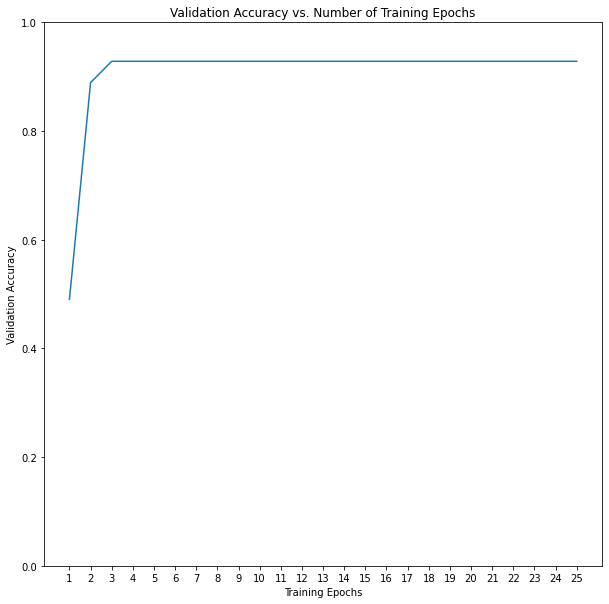

In [54]:
ohist = []
ohist = [h.cpu().numpy() for h in hist]

plt.figure(figsize = (10, 10))
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1, num_epochs + 1), ohist)
plt.ylim((0, 1.))
plt.xticks(np.arange(1, num_epochs + 1, 1.0))
plt.show()